In [97]:
# Import(s)
import sys
import glob
import h5py
import ROOT
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 

from os import environ 
from pandas import read_hdf
from pandas_ml import ConfusionMatrix

In [98]:
# Get input file
input_files = glob.glob('input/Keras*tensorflow*.h5')
assert len(input_files) > 0, \
    "No input files found."
print "Grabbing first input file:",
input_file  = input_files[0]
print input_file

Grabbing first input file: input/Keras_output__D_80_64_32_32_16_8_4_2relu_adam_clipn0_binary_crossentropymytest_tensorflow__lr10_trainBS8192_nE200_s12264_2018-11-02_val10.h5


In [99]:
with h5py.File(input_file, 'r') as f:

    X      = f['X']     [:]
    Y      = f['Y']     [:,1]
    Y_pred = f['Y_pred'][:,1]
    
    print "X     .shape:", X     .shape
    print "Y     .shape:", Y     .shape
    print "Y_pred.shape:", Y_pred.shape
    
    mv2c_Lead    = f['baseline_tagger'][:,0]
    mv2c_SubLead = f['baseline_tagger'][:,1]

    jet_pt   = f['jet_pt']  [:] / 1000.
    jet_mass = f['jet_mass'][:] / 1000.
    jet_eta  = f['jet_eta'] [:]
    
    W_train  = f['W_train'] [:]
    W_test   = f['W_test']  [:]
    classes  = f['class']   [:]
    
    print "classes .shape:", classes.shape
    pass

X     .shape: (354747, 100)
Y     .shape: (354747,)
Y_pred.shape: (354747,)
classes .shape: (354747,)


In [100]:
df0 = pd.DataFrame({"weight":  W_test,   # W_test
                    "Y_pred":  Y_pred.ravel(),
                    "Y":       Y.ravel(), 
                    "classes": classes.ravel(),
                    "mv2c_Lead":    mv2c_Lead.ravel(),
                    "mv2c_SubLead": mv2c_SubLead.ravel(), 
                    "jet_pt":       jet_pt.ravel(),
                    "jet_mass":     jet_mass.ravel(),
                    "jet_eta":      jet_eta.ravel(),
                   })

df0['single_b_mv2c'] = df0[['mv2c_Lead', 'mv2c_SubLead']].max(axis=1)
df0['double_b_mv2c'] = df0[['mv2c_Lead', 'mv2c_SubLead']].min(axis=1)

Predicted   False    True  __all__
Actual                            
False       95581    7181   102762
True        12352  239633   251985
__all__    107933  246814   354747


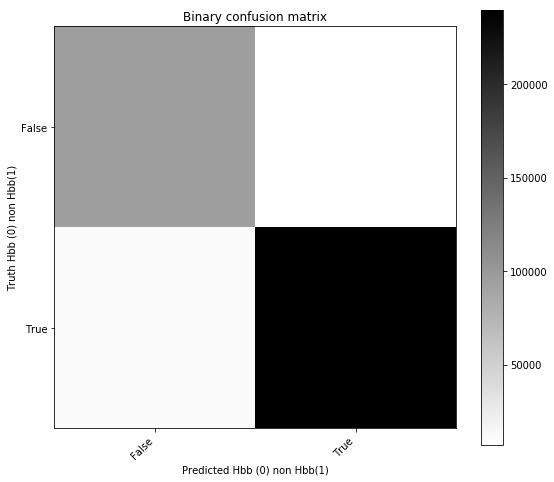

In [101]:
def confusion (df):
    
    # Compute confusion matrix
    confusion_matrix = ConfusionMatrix(df['Y'], df['classes'])

    print (confusion_matrix)

    confusion_matrix.plot()
    plt.xlabel('Predicted Hbb (0) non Hbb(1)' )
    plt.ylabel('Truth Hbb (0) non Hbb(1)')
    plt.show()
    return

#msk = (df0['jet_pt'] > 400.) & (df0['jet_pt'] < 600.)
confusion(df0)

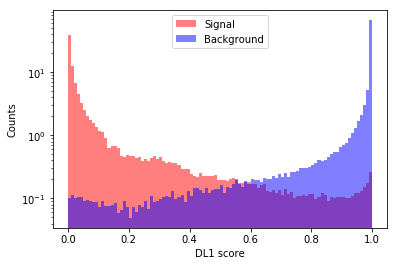

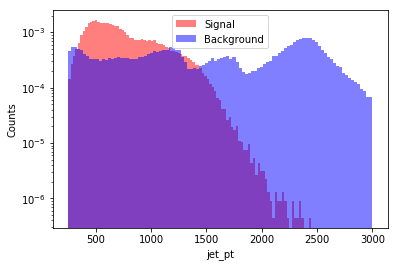

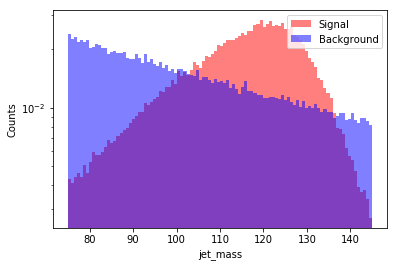

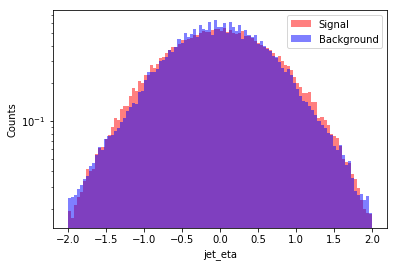

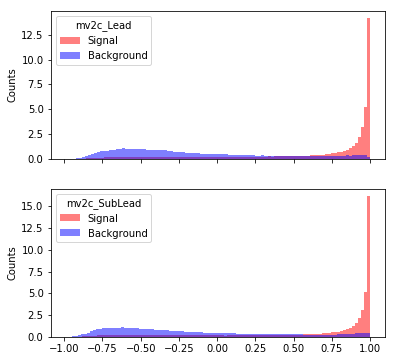

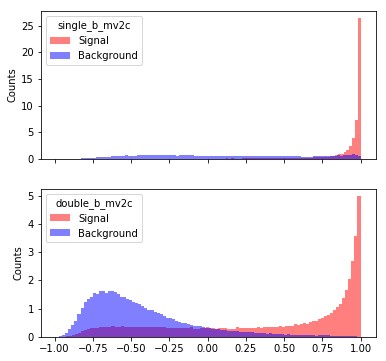

In [102]:
def plot_distribution (df, var, name=None, bins=None):
    
    msk_sig     = (df['Y'] == 0)
    msk_outlier = (df['weight'] > 1000000.)

    fig, ax = plt.subplots(figsize=(6,4))
    plt.hist(df.loc[ msk_sig & ~msk_outlier, var], weights=df.loc[ msk_sig & ~msk_outlier, 'weight'], bins=bins, alpha=0.5, color='red',  label='Signal',     density=1.)
    plt.hist(df.loc[~msk_sig & ~msk_outlier, var], weights=df.loc[~msk_sig & ~msk_outlier, 'weight'], bins=bins, alpha=0.5, color='blue', label='Background', density=1.)
    plt.xlabel(name or var)
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.legend()
    return

def plot_stack (df, vars, bins=None):
    
    N = len(vars)
    msk_sig     = (df['Y'] == 0)
    msk_outlier = (df['weight'] > 100.)

    fig, axes = plt.subplots(len(vars), figsize=(6, 3 * N), sharex=True)
    for ix, (var, ax) in enumerate(zip(vars, axes)):
        ax.hist(df.loc[ msk_sig & ~msk_outlier, var], weights=df.loc[ msk_sig & ~msk_outlier, 'weight'], bins=bins, alpha=0.5, color='red',  label='Signal',     density=1.)
        ax.hist(df.loc[~msk_sig & ~msk_outlier, var], weights=df.loc[~msk_sig & ~msk_outlier, 'weight'], bins=bins, alpha=0.5, color='blue', label='Background', density=1.)
        ax.set_ylabel('Counts')
        ax.legend(title=var)
        pass
    return

# Plot tagger distribution
bins = np.linspace(0, 1, 100 + 1, endpoint=True)
plot_distribution(df0, 'Y_pred', 'DL1 score', bins)
plot_distribution(df0, 'jet_pt',   bins=100)
plot_distribution(df0, 'jet_mass', bins=100)
plot_distribution(df0, 'jet_eta',  bins=100)

plot_stack(df0, ['mv2c_Lead', 'mv2c_SubLead'], bins=100)

plot_stack(df0, ['single_b_mv2c', 'double_b_mv2c'], bins=100)

In [83]:
# Get hist file
hist_files = glob.glob('input/hist*tensorflow*.h5')
assert len(hist_files) > 0, \
    "No hist files found."
print "Grabbing first hist file:",
hist_file = hist_files[0]
print hist_file

Grabbing first hist file: input/hist__D_80_64_32_32_16_8_4_2relu_adam_clipn0_binary_crossentropymytest_tensorflow__lr10_trainBS8192_nE200_s12264_2018-11-02_val10.h5


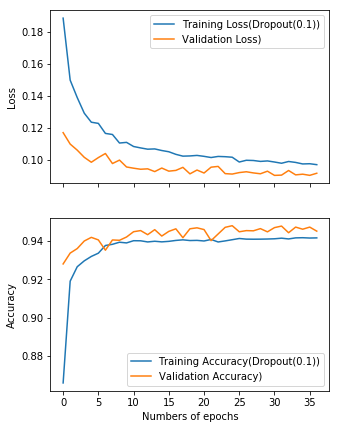

In [84]:
# Load history from file
history = pd.read_hdf(hist_file, key='history')

# Plot loss evolution
fig, ax = plt.subplots(2, figsize=(5,7), sharex=True)

train_loss = history['loss']
val_loss   = history['val_loss']
train_acc  = history['acc']
val_acc    = history['val_acc']

epochs = np.arange(len(train_loss))

ax[0].plot(epochs, train_loss, label='Training Loss(Dropout(0.1))')
ax[0].plot(epochs, val_loss,   label='Validation Loss)')
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(epochs, train_acc, label='Training Accuracy(Dropout(0.1))')
ax[1].plot(epochs, val_acc,   label='Validation Accuracy)')
ax[1].set_xlabel('Numbers of epochs')
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [85]:
msk_sig = (df0['Y'] == 0)
print df0.loc[ msk_sig, 'weight'].mean(), df0.loc[ msk_sig, 'weight'].sum()
print df0.loc[~msk_sig, 'weight'].mean(), df0.loc[~msk_sig, 'weight'].sum()

9.758477677482312e-07 0.10028006830934373
3.962652252104097e-07 0.09985289277464508


In [86]:
num   = df0.loc[ msk_sig, ['jet_pt', 'jet_eta', 'weight']]
denom = df0.loc[~msk_sig, ['jet_pt', 'jet_eta', 'weight']]

(251985,) (251985,)
[ 250.05003125  293.96806563  337.8861      381.80413437  425.72216875
  469.64020312  513.5582375   557.47627188  601.39430625  645.31234063
  689.230375    733.14840938  777.06644375  820.98447813  864.9025125
  908.82054687  952.73858125  996.65661563 1040.57465    1084.49268438
 1128.41071875 1172.32875313 1216.2467875  1260.16482188 1304.08285625
 1348.00089063 1391.918925   1435.83695938 1479.75499375 1523.67302813
 1567.5910625  1611.50909688 1655.42713125 1699.34516563 1743.2632
 1787.18123438 1831.09926875 1875.01730313 1918.9353375  1962.85337188
 2006.77140625 2050.68944063 2094.607475   2138.52550938 2182.44354375
 2226.36157813 2270.2796125  2314.19764687 2358.11568125 2402.03371563
 2445.95175   ]
(50, 10)


/Users/asogaard/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide
/Users/asogaard/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide


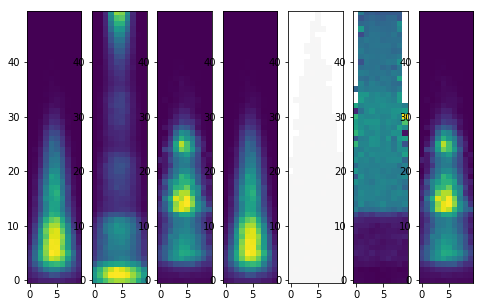

In [96]:
bins_pt, bins_eta = 50, 10
bins_pt  = np.linspace(num['jet_pt'] .min(), num['jet_pt'] .max(), bins_pt  + 1, endpoint=True)
bins_eta = np.linspace(num['jet_eta'].min(), num['jet_eta'].max(), bins_eta + 1, endpoint=True)

h_denom, xedges, yedges = np.histogram2d(denom['jet_pt'], denom['jet_eta'], bins=(bins_pt, bins_eta))
h_num,   _,      _      = np.histogram2d(num  ['jet_pt'], num  ['jet_eta'], bins=(bins_pt, bins_eta))
h_denom = np.clip(h_denom, 1E-05, None)
h_ratio = h_num / h_denom

h_reweight, _, _ = np.histogram2d(denom['jet_pt'], denom['jet_eta'], bins=(bins_pt, bins_eta), weights=denom['weight'])
h_count,    _, _ = np.histogram2d(denom['jet_pt'], denom['jet_eta'], bins=(bins_pt, bins_eta))


h_test = np.zeros(h_num.shape)
for pt, eta in zip(num['jet_pt'], num['jet_eta']):
    ix = np.clip(np.digitize(pt,  xedges) - 1, 0, len(xedges) - 2)
    iy = np.clip(np.digitize(eta, yedges) - 1, 0, len(yedges) - 2)
    h_test[ix,iy] = h_ratio[ix, iy]
    pass

ixs = np.clip(np.digitize(denom['jet_pt'],  xedges) - 1, 0, len(xedges) - 2)
iys = np.clip(np.digitize(denom['jet_eta'], yedges) - 1, 0, len(yedges) - 2)

print h_ratio[ixs, iys].shape, denom['weight'].shape
print "=" * 20

print xedges
print h_reweight.shape

fig, ax = plt.subplots(1, 7, figsize=(8,6))
ax[0].imshow(h_num,                origin='sw')
ax[1].imshow(h_denom,              origin='sw')
ax[2].imshow(h_ratio,              origin='sw')
ax[3].imshow(h_denom * h_ratio,    origin='sw')
ax[4].imshow((h_denom * h_ratio - h_num)/h_num, origin='sw', vmin=-0.01, vmax=0.01, cmap='RdBu')
ax[5].imshow(h_reweight / h_count, origin='sw')
ax[6].imshow(h_test,               origin='sw')

In [ ]:
signal     = df0[(df0['Y']==0)&(df0['jet_pt']<=2000)]
background = df0[(df0['Y']==1)&(df0['jet_pt']<=2000)]

#print(mine)
####################   mv2c  cut

mv2c_sig   = signal    [(signal['single_b_mv2']     > 0.83)]
mv2c_bkg   = background[(background['single_b_mv2'] < 0.83)]
mv2c_bkg_d = background[(background['double_b_mv2'] < 0.11)]

mine_sig = signal[signal['classes']==0]

In [ ]:
print(df['weight'])

import array
import operator

In [ ]:
import ROOT
import array
import operator
#from iteration_utilities import groupedby
#from operator import itemgetter

def getCutValue(disc, weight,eff_target):
        a=np.column_stack((disc, weight))
        a=a[a[:,0].argsort()]
        return a[np.argmin(a[:,1].cumsum() < (1-eff_target)*np.sum(weight)),0]
def getEffCurve(scoreList, varList,weight,  label, bins, scoreCut = None, eff_target = 0.6):
    # initialize histogra
    histName, displayLabel = label

    
    h_base   = ROOT.TH1D(histName+"_beforeCut", histName+"_beforeCut", len(bins)-1, array.array('d', bins))
    h_base.Sumw2()

    h_select = ROOT.TH1D(histName+"_afterCut", histName+"_afterCut", len(bins)-1, array.array('d', bins)) 
    h_select.Sumw2()
    # determine cuts
    scoreCut = getCutValue(scoreList,weight, eff_target)
    print ("score Cut", scoreCut)

    # now loop over data points
    for isampe in range(scoreList.shape[0]):
        score = scoreList[isampe]
        pt = varList[isampe]

        h_base.Fill(pt,weight[isampe])
        if score > scoreCut:
            h_select.Fill(pt,weight[isampe])

    # get efficiency curve
    heff = ROOT.TEfficiency(h_select, h_base)
    heff.SetNameTitle(histName, displayLabel)

    return heff

    
def getFixEffCurve(scoreList, varList,weight, weight_bkg, LightscoreList, LightvarList, label, bins, scoreCut = None, fix_eff_target = 0.6):
        # get pt-dependent cut in order to reach a fixed efficiency for each pT bin                                                                                                                                                                                           
  #      print ("varlist ", varList)
  #      print ("ptbins", bins)
    
 #if scoreCutList is None:
        scoreCutList = []
        print(fix_eff_target)
        for ibin in range(len(bins)-1):
                        ptmin = bins[ibin]
                        ptmax = bins[ibin+1]
                        scoreList_ptslice = scoreList[ np.logical_and(varList>=ptmin, varList<ptmax) ]
                        weight_ptslice = weight[ np.logical_and(varList>=ptmin, varList<ptmax) ]
                       # print(scoreList_ptslice )
                        scoreCutList.append(getCutValue(scoreList_ptslice,weight_ptslice, fix_eff_target))
        weight=np.array(weight)
        weight_bkg=np.array(weight_bkg)
        print (scoreCutList) 
       #if onlyReturnCutList:
       #     return scoreCutList
       # print(label)
        histName, displayLabel = label

        h_base   = ROOT.TH1D(histName+"_beforeCut", histName+"_beforeCut", len(bins)-1,array.array('d', bins))
        h_base.Sumw2()
        
        h_select = ROOT.TH1D(histName+"_afterCut", histName+"_afterCut", len(bins)-1, array.array('d', bins))
        h_select.Sumw2()
       # print(weight_bkg)
        for isampe in range(np.shape(LightscoreList)[0]):
                score = LightscoreList[isampe]
                pt = LightvarList[isampe]
          #      print(np.shape(weight_bkg))
          #      print(np.shape(LightvarList))
                
                wt_bkg=weight_bkg[isampe]
          #      print(isampe, weight_bkg)
                if pt < bins[0]: continue
                if pt >= bins[-1]: continue

                ptbin = np.digitize(pt, bins)-1
                scoreCut = scoreCutList[ptbin]

                h_base.Fill(pt, wt_bkg)
                if score > scoreCut:
                        h_select.Fill(pt,wt_bkg)

        heff = ROOT.TEfficiency(h_select, h_base)
        heff.SetNameTitle(histName, displayLabel)

        return heff

In [ ]:
#def getCutValue(disc, weight,eff_target):
#       # print( disc)
#        return np.sort(disc)[ int((1.0-eff_target)*len(disc)) ]

In [ ]:
ptbins=(np.arange(8)+np.ones(8))*70+520
#ptbins=(np.arange(10)+np.ones(10))*200
#ptbins=ptbins+np.ones(19)*50
print(ptbins[:])
varList=np.array(df0['jet_pt'])
#print(varList)
scoreList=np.array(df0['Y0'])
#print(scoreList)
#print(getFixEffCurve(scoreList, varList, "bb", ptbins, 0.7 ))

In [ ]:
def MultipleEffCurve(outputName, approachList, bins, scoreCut = None, eff_target = 0.6):
    fout = ROOT.TFile(outputName, "recreate")
    for scoreList, varList, weight,  label in approachList:
        print(label)
        heff = getEffCurve(scoreList, varList, weight, label, bins,  eff_target)
        fout.WriteTObject(heff, heff.GetName(), "Overwrite")

    fout.Close()


In [ ]:
def getLRejCurveFixedEff(scoreList, varList,weight, weight_bkg, LightscoreList, LightvarList, label, bins, scoreCut = None, eff_target = 0.6):
	# initialize histogram
	histName, displayLabel = label

	h_base   = ROOT.TH1D(histName+"_beforeCut", histName+"_beforeCut", len(bins)-1, array.array('d', bins))
	h_base.Sumw2()

	h_select = ROOT.TH1D(histName+"_afterCut", histName+"_afterCut", len(bins)-1, array.array('d', bins)) 
	h_select.Sumw2()
	weight=np.array(weight)
	weight_bkg=np.array(weight_bkg)
	print(weight_bkg[1])
    
	# determine cuts for bjets
	if scoreCut is None:
		#scoreCut = getCutValue(scoreList, weight, eff_target)
		scoreCut = getCutValue(scoreList, weight, eff_target)
		print(scoreCut)
   
	# now loop over data points of ljets
	for isampe in range(np.shape(LightscoreList)[0]):
		score = LightscoreList[isampe]
		pt = LightvarList[isampe]
    
		print(weight_bkg[isampe])
		h_base.Fill(pt,weight_bkg[isampe])
		if score > scoreCut:
			h_select.Fill(pt,weight_bkg[isampe])

	# get efficiency curve
	heff = ROOT.TEfficiency(h_select, h_base)
	heff.SetNameTitle(histName, displayLabel)

	return heff
#scoreList, varList, label, bins, fix_eff_target, scoreCutList=None, onlyReturnCutList=False
def MultipleRejCurve(outputName, approachList,weight,weight_bkg, bins, scoreCut = None, eff_target = 0.6):

	fout = ROOT.TFile(outputName, "update")

	for scoreList, varList, LightscoreList, LightvarList, label in approachList:
		heff = getFixEffCurve(scoreList, varList,weight, weight_bkg, LightscoreList, LightvarList, label, bins)
		fout.WriteTObject(heff, heff.GetName(), "Overwrite")

	fout.Close()


In [ ]:
outputName="eff_plot.root"
approachList=[]
approachList.append((np.array(df['Y0']),np.array(df['jet_pt']),np.array(df['weight']),("DL training","60%")))
approachList.append((np.array(df['double_b_mv2']),np.array(df['jet_pt']),np.array(df['weight']),("double_b_mv2","60%")))
approachList.append((np.array(df['single_b_mv2']),np.array(df['jet_pt']),np.array(df['weight']),("single_b_mv2","60%")))

MultipleEffCurve(outputName, approachList,ptbins)



In [ ]:
pt_pred =pd.DataFrame({"weight":weight.ravel(),"classes":classes.ravel(),"Y":Y.ravel(),"Y_pred":Y_pred[:,0].ravel(), "mv2c_Lead":mv2c_Lead.ravel(),"mv2c_SubLead":mv2c_SubLead.ravel(), "jet_pt":jet_pt.ravel()})
pt_pred['dl_score']=np.log(pt_pred['Y_pred']/(1-pt_pred['Y_pred']))
pt_pred['single_b_mv2']=pt_pred[['mv2c_Lead', 'mv2c_SubLead']].max(axis=1)
pt_pred['double_b_mv2']=pt_pred[['mv2c_Lead', 'mv2c_SubLead']].min(axis=1)

pt_pred_h=pt_pred[(pt_pred['jet_pt']>1200)&(pt_pred['jet_pt']<2000)]
pt_pred_m=pt_pred[(pt_pred['jet_pt']>500)&(pt_pred['jet_pt']<800)]
pt_pred_l=pt_pred[(pt_pred['jet_pt']>300)&(pt_pred['jet_pt']<500)]
#print(pt_pred_h)
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(pt_pred[pt_pred['Y']==0]['jet_pt'], 400,normed=0, weights= pt_pred[pt_pred['Y']==0]['weight'],color='r',  label='Signal Leading subjets')                                                          
ax1.hist(pt_pred[pt_pred['Y']==1]['jet_pt'], 400,normed=0, weights= pt_pred[pt_pred['Y']==1]['weight'],color='b',   label='bkg Leading subjets')                                                          
ax1.set_yscale('log')
fig.show()

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(pt_pred[pt_pred['Y']==0]['mv2c_Lead'], 400,normed=0, weights= pt_pred[pt_pred['Y']==0]['weight'],color='r',  label='Signal Leading subjets')                                                          
ax1.hist(pt_pred[pt_pred['Y']==1]['mv2c_Lead'], 400,normed=0, weights= pt_pred[pt_pred['Y']==1]['weight'],color='b',   label='bkg Leading subjets')                                                          


ax1.legend()
ax2.hist(pt_pred[pt_pred['Y']==0]['mv2c_SubLead'], 400,normed=0, weights= pt_pred[pt_pred['Y']==0]['weight'],color='r', label='Signal SubLeading subjets')                                                          
ax2.hist(pt_pred[pt_pred['Y']==1]['mv2c_SubLead'], 400,normed=0, weights= pt_pred[pt_pred['Y']==1]['weight'],color='b',   label='bkg SubLeading subjets')                                                          

#ax1.set_yscale('log')
plt.xlabel('MV2C score')
plt.legend()
fig.savefig('mv2c_subjet.pdf')
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(pt_pred[pt_pred['Y']==0]['single_b_mv2'], 400,normed=0, weights= pt_pred[pt_pred['Y']==0]['weight'],color='r',  label='Signal Single-b')                                                          
ax1.hist(pt_pred[pt_pred['Y']==1]['single_b_mv2'], 400,normed=0, weights= pt_pred[pt_pred['Y']==1]['weight'],color='b',  label='bkg Single-b')                                                          

ax1.legend()
ax2.hist(pt_pred[pt_pred['Y']==0]['double_b_mv2'], 400,normed=0, weights= pt_pred[pt_pred['Y']==0]['weight'],color='r',  label='Signal double_b')                                                          
ax2.hist(pt_pred[pt_pred['Y']==1]['double_b_mv2'], 400,normed=0, weights= pt_pred[pt_pred['Y']==1]['weight'],color='b',  label='bkg double_b')                                                          

#ax1.set_yscale('log')
plt.xlabel('MV2C score')
plt.legend()
#print(np.shape(pt_pred_h[(pt_pred_h['Y']!=pt_pred_h['classes'])&(pt_pred_h['Y']!=0)]))
#plt.hist(pt_pred['Y_pred'],200,weights= pt_pred['weight'],histtype='step')
plt.show()

fig.savefig('sig_double.pdf')

In [ ]:
outputName="rej_plot.root"
approachList=[]
print(np.shape(np.array(df['Y0'])))
print(np.shape(np.array(df['jet_pt'])))
approachList.append((np.array(df['Y0']),np.array(df['jet_pt']),np.array(bkg['Y0']),np.array(bkg['jet_pt']),("DL training","60%")))
approachList.append((np.array(df['double_b_mv2']),np.array(df['jet_pt']),np.array(bkg['double_b_mv2']),np.array(bkg['jet_pt']),("double_b_mv2","60%")))
approachList.append((np.array(df['single_b_mv2']),np.array(df['jet_pt']),np.array(bkg['single_b_mv2']),np.array(bkg['jet_pt']),("single_b_mv2","60%")))
weight=df['weight']
weight_bkg=bkg['weight']
MultipleRejCurve(outputName, approachList, weight, weight_bkg, ptbins)



In [ ]:
outputName="rej_plot.root"
approachList=[]

approachList.append((np.array(df['Y0']),np.array(df['jet_pt']),np.array(bkg['Y0']),np.array(bkg['jet_pt']),("DL training","60%")))
approachList.append((np.array(df['double_b_mv2']),np.array(df['jet_pt']),np.array(bkg['double_b_mv2']),np.array(bkg['jet_pt']),("double_b_mv2","60%")))
approachList.append((np.array(df['single_b_mv2']),np.array(df['jet_pt']),np.array(bkg['single_b_mv2']),np.array(bkg['jet_pt']),("single_b_mv2","60%")))
weight=df['weight']
weight_bkg=bkg['weight']
MultipleRejCurve(outputName, approachList, weight,weight_bkg, ptbins)

In [ ]:
def ConvertEffToGraph(effplot, bins, doEff=True):
    print (effplot)
    eff = []
    efferror = []
    print(bins, len(bins))
    for i in range(len(bins)-1):
        if doEff:
            eff.append(effplot.GetEfficiency(i+1))
            efferror.append(effplot.GetEfficiencyErrorLow(i+1))
        else:
            if (effplot.GetEfficiency(i+1)==0):
                eff.append(1)
                efferror.append( effplot.GetEfficiencyErrorLow(i+1)/1 )
            else:
                eff.append(1./(effplot.GetEfficiency(i+1)))
                efferror.append( (effplot.GetEfficiencyErrorLow(i+1)/effplot.GetEfficiency(i+1))/effplot.GetEfficiency(i+1) )


    bins=bins+np.ones(8)*100
    bins=bins[:-1]
    
    newgraph = ROOT.TGraphErrors (len(bins), array.array('d', bins), array.array('d', eff), array.array('d', [0]*len(bins)), array.array('d', efferror))
    return newgraph
    #for i in range(len(bins)):
    #    newgraph.SetBinError(i+1, eff[i])

def GetRelativeRej(rejplot1, rejplot2, bins):
    rel = []
    relerror = []

    for i in range(len(bins)):
        rel.append( rejplot1.GetEfficiency(i+1)/rejplot2.GetEfficiency(i+1) )
        relerror.append( rel[i]*sqrt( (rejplot1.GetEfficiencyErrorLow(i+1)/rejplot1.GetEfficiency(i+1))**2 + (rejplot2.GetEfficiencyErrorLow(i+1)/rejplot2.GetEfficiency(i+1))**2 ) )

    newgraph = ROOT.TGraphErrors (len(bins), array.array('d', bins), array.array('d', rel), array.array('d', [0]*len(bins)), array.array('d', relerror))
    return newgraph

In [ ]:
outputName="eff_plot.root"
file=ROOT.TFile(outputName, "r")
dltree=file.Get("DL training")
dmtree=file.Get("double_b_mv2")
smtree=file.Get("single_b_mv2")
EffCurves = [dltree,dmtree,smtree]
label = ["DL training(60% WP)","Baseline double-btagged subjets(60% WP)","Baseline single-btagged subjets(60% WP)"]
legend = ROOT.TLegend(0.1, 0.7, 0.5, 0.9)
legend_rel = ROOT.TLegend(0.1, 0.7, 0.5, 0.9)
colorlist=[2,8,38]
ROCs = []
varname="eff"
canvas = ROOT.TCanvas(varname, varname, 800, 600)
mg = ROOT.TMultiGraph()
mg_rel = ROOT.TMultiGraph()

for i in range(len(EffCurves)):

    ROC = ConvertEffToGraph(EffCurves[i],ptbins, True)

    ROC.SetLineWidth(2)
    ROC.SetLineColor(colorlist[i])
    ROC.SetMarkerColor(colorlist[i])
    ROC.SetMarkerStyle(1)
    mg.SetTitle("Hbb-tagging efficiency for a fixed 60% WP cut Vs Large R-jet pT;Jet Pt(GeV); Hbb-tagging efficiency")

    mg.Add(ROC)

    legend.AddEntry(ROC, label[i], "lp")

    ROCs.append(ROC)

mg.Draw("AL*")
mg.GetHistogram().SetMaximum(1.)
legend.Draw("same")
canvas.SaveAs("eff.pdf")

file.Close()
canvas.Close()

In [ ]:
import ROOT
outputName="rej_plot.root"
file=ROOT.TFile(outputName, "r")
dltree=file.Get("DL training")
dmtree=file.Get("double_b_mv2")
smtree=file.Get("single_b_mv2")
EffCurves = [dltree,dmtree,smtree]
label = ["DL training(60% WP)","Baseline double-btagged subjets(60% WP)","Baseline single-btagged subjets(60% WP)"]
legend = ROOT.TLegend(0.1, 0.7, 0.5, 0.9)
legend_rel = ROOT.TLegend(0.1, 0.7, 0.5, 0.9)
colorlist=[2,8,38]

varname="rej"
canvas = ROOT.TCanvas(varname, varname, 800, 600)
mg = ROOT.TMultiGraph()
mg_rel = ROOT.TMultiGraph()

for i in range(len(EffCurves)):

    ROC = ConvertEffToGraph(EffCurves[i],ptbins, False)

    ROC.SetLineWidth(2)
    ROC.SetLineColor(colorlist[i])
    ROC.SetMarkerColor(colorlist[i])
    ROC.SetMarkerStyle(1)
    #mg.GetYaxis().SetTitle("Dijet Rejection")
    mg.Add(ROC)
    mg.SetTitle("Dijets rejection at flat Hbb-tagging efficiency of 60% vs Large R-jet pT;Jet Pt(GeV); Dijets Rejection")


    legend.AddEntry(ROC, label[i], "lp")

    ROCs.append(ROC)

mg.Draw("AL*")
mg.GetHistogram().SetMaximum(75.)

legend.Draw("same")

canvas.SaveAs("rej.pdf")

file.Close()
canvas.Close()

In [ ]:
fig, (ax1) = plt.subplots(nrows=1)
import math
#print(pt_pred[pt_pred['Y']==0]['Y_pred'])
#print(pt_pred[pt_pred['Y']==1]['Y_pred'])
#for i in range(0,2):
  #  print(i)1
    #ratio[i]=pt_pred[pt_pred['Y']==i]['weight'].sum()
    #ratio[i]=1pt_pred['Y_pred']#
pt_pred['dl_score']=pt_pred['Y_pred']#np.log(pt_pred['Y_pred']/(1-pt_pred['Y_pred']))#

#print (pt_pred)
#print (dl)
#pt_pred['dl_score']=pt_pred['dl_score']/(pt_pred['dl_score'].max(axis=0)-pt_pred['dl_score'].min(axis=0))
#pt_pred['dl_score']=pt_pred['Y_pred']
ax1.hist(pt_pred[pt_pred['Y']==0]['dl_score'],100,weights=pt_pred[pt_pred['Y']==0]['weight'], label='signal Higgs bb',color='r', normed=1)
ax1.hist(pt_pred[pt_pred['Y']==1]['dl_score'],100,weights=pt_pred[pt_pred['Y']==1]['weight'],  label='bkg non-Higgs bb',color='b', normed=1)
#ax1.hist(pt_pred[pt_pred['Y']==0]['dl_score'],200,weights=pt_pred[pt_pred['Y']==0]['weight'], histtype='step', label='signal Higgs bb',color='r', normed=1)
#ax1.hist(pt_pred[pt_pred['Y']==1]['dl_score'],200,weights=pt_pred[pt_pred['Y']==1]['weight'], histtype='step', label='bkg non-Higgs bb',color='b', normed=1)
ax1.legend()
plt.xlabel('DL1 score')


      
fig.savefig("DL_score.pdf")
#ax1.set_xlim(-1,1)
#ax1.set_yscale('log')
fig, (ax2, ax3, ax4) = plt.subplots(nrows=3)
ax2.hist(pt_pred_h[pt_pred_h['Y']==0]['Y_pred'],200,weights= pt_pred_h[pt_pred_h['Y']==0]['weight'],label='pt:[300,500]GeV',color='r', normed=1)
ax3.hist(pt_pred_m[pt_pred_m['Y']==0]['Y_pred'],200,weights= pt_pred_m[pt_pred_m['Y']==0]['weight'],label='pt:[500,800]GeV',color='r',normed=1)
ax4.hist(pt_pred_l[pt_pred_l['Y']==0]['Y_pred'],200,weights= pt_pred_l[pt_pred_l['Y']==0]['weight'],label='pt:[1200,2000]GeV', color='r',normed=1)
ax2.hist(pt_pred_h[pt_pred_h['Y']==1]['Y_pred'],200,weights= pt_pred_h[pt_pred_h['Y']==1]['weight'],label='bkg pt:[300,500]GeV',color='b', normed=1)
ax3.hist(pt_pred_m[pt_pred_m['Y']==1]['Y_pred'],200,weights= pt_pred_m[pt_pred_m['Y']==1]['weight'],label='bkg pt:[500,800]GeV',color='b', normed=1)
ax4.hist(pt_pred_l[pt_pred_l['Y']==1]['Y_pred'],200,weights= pt_pred_l[pt_pred_l['Y']==1]['weight'],label='bkg pt:[1200,2000]GeV',color='b', normed=1)
#ax2.set_xlim(-1,1)
#ax3.set_xlim(-1,1)
#ax4.set_xlim(-1,1)

ax2.legend()
ax3.legend()
ax4.legend()
#plt.yscale('log')
plt.legend()
plt.xlabel('DL1 score')

plt.show()

      
fig.savefig("DL_score_pt.pdf")
#plt.hist(Y_pred[:,0],200,histtype='step')
plt.close


In [ ]:
from sklearn import metrics
#print(np.shape(mine))
#print(np.shape(mine_bkg))
#print(Y_pred[0,:])
fig, ax1 = plt.subplots(nrows=1)

#dl=(df0['Y0']<0.958226).astype(int)
roc_dl=metrics.accuracy_score(Y, classes)

#x=mv2c['single_b_mv2']
#class_mv2=(df0['single_b_mv2']<cut_single).astype(int)
#class_mv2_d=(df0['double_b_mv2']<cut_double).astype(int)


#np.where(x>0.83)
#print(x)
#y=x.astype(int)
    
#print(y)
#roc_mv= metrics.accuracy_score(Y,  class_mv2)
#roc_mv_d= metrics.accuracy_score(Y, class_mv2_d)

fpr, tpr, thresholds = metrics.roc_curve(df0['Y'],df0['Y0'],pos_label=0,sample_weight=df0['weight'])
#plt.show()
#print (tpr)
plt.plot(fpr,tpr,'r',label='DL score: %0.2f' % roc_dl)

#mv_class=((df0['double_b_mv2']>0.64))
#mv_class=((df0['_b_mv2']>0.64))
#print (fpr1,tpr1, thresholds)
#print(np.shape(Y))
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y, df0['double_b_mv2'], pos_label=0,sample_weight=df0['weight'])

plt.plot(fpr1,tpr1,'b', label='baseline double b-subjet')
fpr10, tpr10, thresholds10 = metrics.roc_curve(Y,df0['single_b_mv2'], pos_label=0,sample_weight=df0['weight'])

plt.plot(fpr10,tpr10,'g', label='baseline single b-subjet')

#fpr3, tpr3, thresholds3 = metrics.roc_curve(Y1,Y_pred1[:,0],pos_label=0,sample_weight=weight1)
#plt.plot(fpr3,tpr3,'y', label='DL Training(5 classes)')
plt.legend(bbox_to_anchor=(0.9,0.3),fontsize=15)
#plt.xlabel('Higgs bb tagging efficiency')
#plt.ylabel('non-bb rejection')
plt.xlabel('FPF')
plt.title('ROC curve')
plt.ylabel('TPF')
plt.show() 
#print (weight)
# Print AUC
#auc = np.trapz(tpr,fpr)
fig.savefig("ROC.pdf")



In [ ]:
#print(((pt_pred['Y']==0)&(pt_pred['classes']==0)))
#pt_pred
fig, ax1 = plt.subplots(nrows=1)


#pt_pred=pt_pred[(pt_pred['jet_pt']<2000)&(pt_pred['jet_pt']>0)]
#pt_pred1=pt_pred1[(pt_pred1['jet_pt']<2000)&(pt_pred1['jet_pt']>0)]
sig_ind=(pt_pred['Y']==0)
bkg_ind=(pt_pred['Y']==1)
#sig_ind1=(pt_pred1['Y']==0)
#bkg_ind1=(pt_pred1['Y']!=1)
#print(pt_pred)
#print (sig_ind, bkg_ind)



sig2,_=np.histogram(pt_pred[pt_pred['Y']==0]['double_b_mv2']/2,5000)
#weight_sig,_=np.histogram(pt_pred['weight'][sig_ind],5000)
#print(np.shape(sig),np.shape(weight_sig))
bkg2,_=np.histogram(pt_pred[pt_pred['Y']==1]['double_b_mv2']/2,5000)
#weight_bkg,_=np.histogram(pt_pred['weight'][bkg_ind],5000)
#print(sig)
sig_eff2=np.add.accumulate(sig2[::-1])/np.sum(sig_ind)
bkg_rej2=np.add.accumulate(bkg2[::-1])/np.sum(bkg_ind)


sig21,_=np.histogram(pt_pred[pt_pred['Y']==0]['single_b_mv2']/2,5000)
#weight_sig,_=np.histogram(pt_pred['weight'][sig_ind],5000)
#print(np.shape(sig),np.shape(weight_sig))
bkg21,_=np.histogram(pt_pred[pt_pred['Y']==1]['single_b_mv2']/2,5000)
#weight_bkg,_=np.histogram(pt_pred['weight'][bkg_ind],5000)
#print(sig)
sig_eff21=np.add.accumulate(sig21[::-1])/np.sum(sig_ind)
bkg_rej21=np.add.accumulate(bkg21[::-1])/np.sum(bkg_ind)
#print(pt_pred1)
#sig1,_=np.histogram(pt_pred1[pt_pred1['Y']==0]['dl_score'],5000)
#weight_sig1,_=np.histogram(pt_pred1['weight'][sig_ind1],5000)
#bkg1,_=np.histogram(pt_pred1[pt_pred1['Y']==1]['dl_score'],5000)
#weight_bkg1,_=np.histogram(pt_pred1['weight'][bkg_ind1],5000)

#sig_eff1=np.add.accumulate(sig1[::-1])/np.sum(sig_ind1)
#bkg_rej1=np.add.accumulate(bkg1[::-1])/np.sum(bkg_ind1)

sig,_=np.histogram(pt_pred[pt_pred['Y']==0]['Y_pred'],5000)
#weight_sig,_=np.histogram(pt_pred['weight'][sig_ind],5000)
bkg,_=np.histogram(pt_pred[pt_pred['Y']==1]['Y_pred'],5000)
#weight_bkg,_=np.histogram(pt_pred['weight'][bkg_ind],5000)
sig_eff=np.add.accumulate(sig[::-1])/np.sum(sig_ind)
bkg_rej=np.add.accumulate(bkg[::-1])/np.sum(bkg_ind)


#plt.hist(sig_eff,100)
plt.plot(sig_eff, 1/bkg_rej,'r',label='DL score')
#plt.plot(sig_eff1,1/bkg_rej1,'r',label='DL1 5classes')
plt.plot(sig_eff21, 1/bkg_rej21,'b',label='baseline single-b score')
plt.plot(sig_eff2, 1/bkg_rej2,'g',label='baseline double_b score')
plt.yscale('log')
plt.legend(fontsize=15)

plt.xlabel('Higgs bb tagging efficiency')
plt.title('The dijet rejection vs Higgs bb tagging efficiency')
plt.ylabel('Dijet rejection,(1/$\epsilon_{dijet}$)')
#plt.ylim(1,1e5)
#plt.xlim(0,1)
plt.show()
fig.savefig("ROC_ATLAS.pdf")

In [ ]:
import pandas as pd  
import matplotlib.pyplot as plt 
import numpy as np
print  (pd.show_versions())
#file='hist__D_80_64_32_32_16_8_4_2relu_adam_clipn0_binary_crossentropybcujets_pTmax300GeV__b_reweighting_tensorflow__lr10_trainBS256_nE100_s12264_val10.h5'
#file='/Users/elenavillhauer/h_bbar_DL/output_lowpileup_157_559pm/hist__D_80_64_32_32_16_8_4_2__BN_relu_adam_clipn0_binary_crossentropybcujets_pTmax300GeV__b_reweighting_tensorflow__lr10_trainBS128_nE500_s12264_val10.h5'
file='/Users/elenavillhauer/h_bbar_DL/ines_doubleb_small_sample_test/hist__D_80_64_32_32_16_8_4_2relu_adam_clipn0_binary_crossentropybcujets_pTmax300GeV__b_reweighting_tensorflow__lr10_trainBS80_nE200_s12264_2018-09-10_val10.h5'
#/Users/elenavillhauer/h_bbar_DL/lowpileup/hist__D_80_64_32_32_16_8_4_2__BN_relu_adam_clipn0_binary_crossentropybcujets_pTmax300GeV__b_reweighting_tensorflow__lr10_trainBS64_nE100_s12264_val10.h5'
#hist__D_80_64_32_32_16_8_4_2__BN_relu_adam_clipn0_binary_crossentropybcujets_pTmax300GeV__b_reweighting_tensorflow__lr10_trainBS512_nE100_s12264_val10.h5'

fig, ax1 = plt.subplots(nrows=1)
train_loss=pd.read_hdf(file, key='history')['loss']
val_loss=pd.read_hdf(file, key='history')['val_loss']
train_acc=pd.read_hdf(file, key='history')['acc']
val_acc=pd.read_hdf(file, key='history')['val_acc']
#print(train_loss)
plt.plot(np.linspace(0,len(train_loss),len(train_loss)),train_loss,label='Training Loss(Dropout(0.1))')
plt.plot(np.linspace(0,len(val_loss),len(val_loss)),val_loss,label='Validation Loss)')
plt.legend(fontsize=15)
plt.xlabel('Numbers of epochs')
plt.ylabel("Loss")

plt.show()
fig.savefig("loss.pdf")
fig, ax1 = plt.subplots(nrows=1)
plt.plot(np.linspace(0,len(train_acc),len(train_acc)),train_acc,label='Training Accuracy(Dropout(0.1))')
plt.plot(np.linspace(0,len(val_acc),len(val_acc)),val_acc,label='Validation Accuracy)')
plt.xlabel('Numbers of epochs')
plt.ylabel("Accuracy")
#plt.show()
plt.ylim(0.9,.97)
plt.legend(fontsize=15)
plt.show()
fig.savefig("acc.pdf")
#file.close()



In [ ]:
import pandas as pd   
#import wkhtmltoimage
import numpy as np
pd.set_option('precision', 2)
file='/Users/juechen/Documents/course/research/double-bplots/mc_weight.txt'
data = pd.read_csv(file, sep=" ",header = None)
data.columns = ["Filter eff", "cross section", "mcwg(averaged)", "DAOD events #", "Entries with cut(jet-based)"]
data['estimated weight(with averaged mcwg)']=data["Filter eff"]*data["cross section"]*data["mcwg(averaged)"]/data["DAOD events #"]
#data=data[["Filter eff", "cross section", "DAOD event", "Entries after all cut(jet-based)"]]

data.rename({0: "JZ0W", 1: "JZ1W",2: "JZ2W", 3: "JZ3W"})
#print(np.array(data["cross section"]))

data.update(data.find(1.00))
print(data)

In [ ]:
import json
from keras.models import  model_from_json
import tensorflow
import os
json_file = open('/Users/juechen/Documents/course/research/double-bplots/KerasFiles/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/juechen/Documents/course/research/double-bplots/KerasFiles/model.h5")
print("Loaded model from disk")

In [ ]:
a=np.random.randint(5, size=(3,4))
b=np.random.randint(5, size=(3,4))
#print(a)
print(np.where(b==0))

b=np.where(b ==0, 1, b)
print(b)
#print(np.sum(a,axis=0))
#print(np.count_nonzero(b,axis=0))
mean=np.divide(np.sum(a,axis=0),np.count_nonzero(b,axis=0))
print(mean)
pt=np.ones(len(a))
pt.shape=(len(a),1)
mean.shape=(len(a[0]),1)
mean=pt*mean.T

weight=np.divide(mean,b)

print(mean)
#weight[weight == inf] = 0

print(weight)

In [ ]:
def find_nearest1D(array,value):                                                                                                                                                                                                                           
     #check if value is below lowest or above higest bin edge,                                                                                                                                                                                             
     highBin = array[-1]                                                                                                                                                                                                                                   
     lowbin = array[0]                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                           
     if value >= highBin:                                                                                                                                                                                                                                  
         return str(array[-2])+'_'+str(array[-1])                                                                                                                                                                                                          
     if value < lowbin:                                                                                                                                                                                                                                    
         return str(array[0])+'_'+str(array[1])                                                                                                                                                                                                            
                                                                                                                                                                                                                                                           
     idxLow = (np.abs(array[array <= value]-value)).argmin()                                                                                                                                                                                               
     idxHigh = (np.abs(array[array > value]-value)).argmin()                                                                                                                                                                                               
                                                                                                                                                                                                                                                           
     return str(array[array <= value][idxLow])+'_'+str( array[array > value][idxHigh] )                                                                                                                                                                    
                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                           
def find2dBin(xval, yval, xbins, ybins):                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                           
     xbinning = find_nearest1D(xbins,xval)                                                                                                                                                                                                                 
     ybinning = find_nearest1D(ybins,yval)                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                           
     return xbinning+'_'+ybinning                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                           
def makeBinValueDict(array,x_edges,y_edges):                                                                                                                                                                                                               
                                                                                                                                                                                                                                                           
     binvaldict = {}                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                           
     for xi in range(len(x_edges)-1):                                                                                                                                                                                                                      
         for yi in range(len(y_edges)-1):                                                                                                                                                                                                                  
             binname = str(x_edges[xi])+'_'+str(x_edges[xi+1])+'_'+str(y_edges[yi])+'_'+str(y_edges[yi+1])                                                                                                                                                 
             binval = array[xi][yi]                                                                                                                                                                                                                        
             if np.isnan(binval):                                                                                                                                                                                                                          
                 binval = 1.0                                                                                                                                                                                                                              
             binvaldict[binname]=binval                                                                                                                                                                                                                    
     return binvaldict                                                                                                                                                                                                                                     
                           

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
ptarray_sig = np.random.normal(0, 1, 100000)
etaarray_sig= np.random.normal(0, 1, 100000)
ptarray_bkg = np.random.normal(0, 2, 100000)
etaarray_bkg= np.random.normal(0, 2, 100000)
ptbins = np.linspace(ptarray_sig.min(),ptarray_sig.max(),50)                                                                                                                                                                                       
etabins = np.linspace(etaarray_sig.min(),etaarray_sig.max(),2)                                                                                                                                                                                    
#print(ptbins)         
fig=plt.subplots(nrows=2)

plt.hist(ptarray_sig,50)
plt.show()

plt.hist(etaarray_sig,50)
plt.show()
plt.hist(ptarray_bkg,50)
plt.show()

plt.hist(etaarray_bkg,50)
plt.show()
Hsig, xedges, yedges = np.histogram2d(ptarray_sig, etaarray_sig, bins=(ptbins, etabins))#, weights=weight_sig)                                                                                                                                         
Hbkg, xedges, yedges = np.histogram2d(ptarray_bkg, etaarray_bkg, bins=(ptbins, etabins))#, weights=weight_bkg)  
#print(xedges, yedges)

#plt.show()
a = Hsig                                                                                                                                                                                                                                               
b= Hbkg                                                                                                                                                                                                                                                
mean=np.divide(np.sum(a,axis=0),np.count_nonzero(b,axis=0))      
pt=np.ones(len(a))                         
pt.shape=(len(a),1)                        
mean.shape=(len(a[0]),1)                   
mean=pt*mean.T    
b[b==0]=1
weight=np.divide(mean,b)                                                                                                                                                                                                                               
#from numpy import inf                                                                                                                                                                                                                                     
#weight[weight == ] = 0                                                                                                                                                                                                                                 
weightHist=weight      
#print(weightHist)
weightDict = makeBinValueDict(weightHist,xedges, yedges)     
#print (weightDict )                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
weightarray = []                                                                                                                                                                                                                                         
#loop over background array    
#print(len(ptarray_bkg))
for i in range(len(ptarray_bkg)):                                                                                                                                                                                                                                          
    xval = ptarray_bkg[i]                                                                                                                                                                                                                                            
    yval = etaarray_bkg[i]  
    #print(xval, yval)
    #print(weightDict[find2dBin(xval,yval,xedges,yedges)])
    weightarray.append( weightDict[find2dBin(xval,yval,xedges,yedges)] )   


#print (weightarray  ) 

In [ ]:
fig=plt.subplots(nrows=2)

plt.hist(ptarray_bkg,50,weights=weightarray)
plt.hist(ptarray_sig,50,weights=weightarray, color='r')
plt.show()

plt.hist(etaarray_bkg,50,weights=weightarray)
plt.show()

In [ ]:
import numpy as np
eta_bins = [0., 0.5, 0.75, 1., 2]                                                                                                                                                                                  
eta_bins = [-i for i in eta_bins]+eta_bins[1:5]  
print(np.sort(eta_bins))

pt_bins=np.concatenate([np.arange(250,1250,50),np.arange(1250,2200,750)])
print(np.shape(pt_bins))
print(pt_bins)

a=[1,2,12]
print(np.shape(a))
a.shape=(3,1)